In [84]:
import numpy as np
import importlib, os, hashlib, json, sys
source_path = os.path.expanduser('~/source/')
sys.path.append(source_path)

from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
import edward_tools.fq_runner as fq_runner
from edward_tools.visualization import animate_sim_flux_qubit
from edward_tools.initial_state_sampling import self_defined_initial_state, extra_constraint_00_and_11_only

import kyle_tools as kt
import matplotlib.pyplot as plt
from quick_sim import setup_sim


from edward_tools import coupled_fq_protocol_library, cfq_runner
from PARAMETER_INPUT import *
from PARAMETER_INPUT import _lambda, _theta, _eta
from ControlParameter import *

import edward_tools.cfq_batch_sweep as cfq_batch_sweep

In [85]:
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
get_potential_shot_at_different_t_1D = coupled_fq_protocol_library.get_potential_shot_at_different_t_1D
create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
create_system_from_storage_and_computation_protocol = coupled_fq_protocol_library.create_system_from_storage_and_computation_protocol
coupled_fq_runner = importlib.reload(cfq_runner)
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system

In [120]:
sysArgvDict = {"placeholder": "", "tested_paramter_name": "protocolIndex", "tested_paramter_value": 1,
               "test_description": "test_description", "expt_number": 6}
sys.argv = list(sysArgvDict.values())

# In[ ]:
# time_length_x control
# t_total = 100
protocol_index = int(sys.argv[2])
# time_length_1 = t_total * r
# rest_time = t_total * (1-r)
tested_paramter_name = sys.argv[1] 
tested_paramter_value = float(sys.argv[2])
description = sys.argv[3] or "no text"
expt_number = int(sys.argv[4])

In [121]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
params['N'] = N
params['dt'] = dt


In [122]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_c0]
[phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound] = np.array([4, 4, 4, 4])/time_scale_factor

coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_1dc_bound, -phi_2dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound]]

coupled_fq_pot = Potential(coupled_flux_qubit_pot, coupled_flux_qubit_force, 14, 4,\
                           default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)


"""
# step 2: Define initial condition and protocol
"""
manual_domain=[np.array([-5, -5]), np.array([5, 5])]
phi_1_dcx, phi_2_dcx = 0, 0
phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx

initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": gamma,  "gamma_2": gamma,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1 ,   "d_beta_2": d_beta_2,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off,
        "M_12": M_12_off, 'x_c': x_c
}


# time length
time_length_1 = 80
time_length_2 = 40
time_length_3 = 40
time_length_4 = 40
time_length_5 = 60
time_length_6 = 60

In [123]:
protocol_list_options = [
    {"placeholder": ""},
    # forward
    {"duration":time_length_1, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(1) mix in y direction"},
    {"duration":time_length_2, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_on,   "name":"(2) conditional tilt"},
    {"duration":time_length_3, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(3) raise the barrier"},
    {"duration":time_length_4, "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(4) 4 well potential 1st time"}, 
    {"duration":time_length_5, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(5) mix in x direction"}, 
    {"duration":time_length_6, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(6) 4 well potential"}, 
    
    # reverse
    {"duration":time_length_6, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-6) 4 well potential 2nd time"}, 
    {"duration":time_length_5, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-5) anti-mix in x direction"}, 
    {"duration":time_length_4, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(-4) anti-raise the barrier 1st time"},
    {"duration":time_length_3, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12":  M_12_on,  "name":"(-3) anti-raise the barrier"},
    {"duration":time_length_2, "phi_1_dcx":phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(-2) anit-conditional tilt"},
    {"duration":time_length_1, "phi_1_dcx":phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-1) anti- mix in y direction"}
]

# In[34]:

zeroDissipation = False
params['sim_params'] = [_lambda, _theta, _eta]
if zeroDissipation:
    params['sim_params'] = [_lambda * 0, _theta, _eta * 0]

TR_initial_condition = [
    (phi_1_dcx_off, phi_2_dcx_off, M_12_off), 
    (phi_1_dcx_off, phi_2_dcx_on,  M_12_off), 
    (phi_1_dcx_off, phi_2_dcx_on,  M_12_on), 
    (phi_1_dcx_off, phi_2_dcx_off, M_12_on), 
    (phi_1_dcx_off, phi_2_dcx_off, M_12_off), 
    (phi_1_dcx_on,  phi_2_dcx_off, M_12_off)]



In [124]:
# protocol_index = 0

initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"] = TR_initial_condition[protocol_index]
# rest =     {"duration":rest_time, "name": "rest"}

protocol_list = [
    # forward
    protocol_list_options[protocol_index + 1],
    # rest
    # protocol_list_options[1],
    # protocol_list_options[2],
    # protocol_list_options[3],
    # protocol_list_options[4],
    # protocol_list_options[5],
    # rest,
    # protocol_list_options[6],
    
    # reverse
    # protocol_list_options[-5],
    # protocol_list_options[-4],
    # protocol_list_options[-3],
    # protocol_list_options[-2],
    # protocol_list_options[-1]
    protocol_list_options[-(protocol_index + 1)]
]

print(params['sim_params'])
print(initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"])
for x in protocol_list:
    print(x)


[array([0.00269542, 0.00269542, 0.00269542, 0.00269542]), array([1., 4., 1., 4.]), array([0.01310394, 0.02620788, 0.01310394, 0.02620788])]
0 3.0 0
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 3.0, 'M_12': -0.8, 'name': '(2) conditional tilt'}
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 3.0, 'M_12': 0, 'name': '(-2) anit-conditional tilt'}


In [125]:
"""
# step 3: create the relevant storage protocol and computation protocol
"""
computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
                                                                    protocol_list)
storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict)


# In[37]:

"""
# step 4: create the coupled_fq_runner
"""
cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol)
cfqr.initialize_sim()
# cfqr.set_sim_attributes(extra_constraint = extra_constraint_00_and_11_only)
cfqr.set_sim_attributes(extra_constraint = None)
init_state_saved = cfqr.init_state
manual_domain=[np.array([-5, -5])/time_scale_factor, np.array([5, 5])/time_scale_factor]


# In[39]:

generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 10000 samples out of 10000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 10000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 80.0
from simulation.py: number of steps: 8000, dt: 0.01


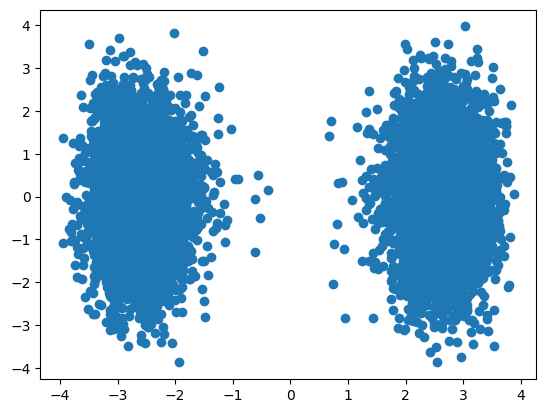

In [126]:
plt.scatter(init_state_saved[:, 0, 0], init_state_saved[:, 1, 0])

In [ ]:
# step 5: perform simulations

simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
                                        initial_state = init_state_saved, manual_domain = manual_domain, \
                                        phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx, \
                                        percentage = 1, \
                                        as_step = np.s_[::100])

cfqr = simResult["cfqr"]
print(simResult["simulation_data"]["simulation_time"])


 initializing...
use old initial_state
as step value: slice(None, None, 100), sampleSize: 10000
slice(None, None, 100)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 80.0
from simulation.py: number of steps: 8000, dt: 0.01

 running sim...


# Work analysis

In [ ]:
# In[40]:


step_time_array = np.cumsum(np.array([x["duration"] for x in protocol_list]))/params['dt']
name_array = [x["name"] for x in protocol_list]

from scipy.stats import sem 


jarzyn_term = np.mean(np.exp(-simResult["work_distribution"]))

avg_W = np.mean(simResult["work_distribution"])
error_W = sem(simResult["work_distribution"])
jarzyn_term_error = np.exp(-avg_W) * error_W

print(f"simulation_id {simResult['simulation_data']['simulation_id']}")
print(f"mean work = {avg_W:.3f} ± {error_W:.5f}")
print(f'jarzyn = {jarzyn_term:.3f} ± {jarzyn_term_error:.5f}')
print([x["duration"] for x in protocol_list])
print(simResult["fidelity"])

# In[42]:
result = {"N": params['N'], "dt": params['dt'], "protocol_list": protocol_list, "W_mean": avg_W, "W_std": error_W, 
          "jarzyn": jarzyn_term, "jarzyn_error": jarzyn_term_error, "fidelity": simResult["fidelity"], 
          "simulation_data": simResult["simulation_data"], "tested_parameter_name": tested_paramter_name,
          "tested_parameter_value": tested_paramter_value, "description": description, "expt_number": expt_number}




## Crook's analysis
By Crooks’ detailed fluctuation theorem, we have
![image.png](attachment:37287cc9-929d-46d9-9ad8-f97562b7a597.png)

In [116]:
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-2, 2, 100),density=True)
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-0.5, 0.5, 30),density=True)

In [117]:
log_P_ratio = np.log(counts / counts[::-1])


Text(0, 0.5, 'log ratio')

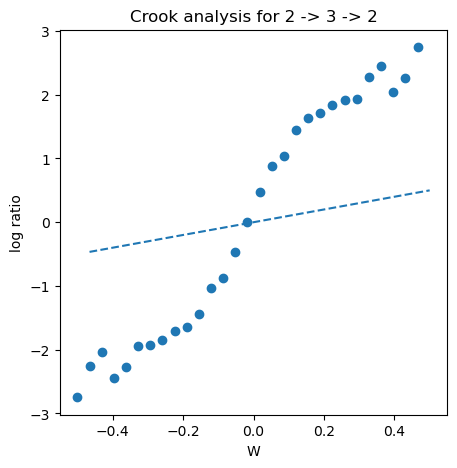

In [119]:
plt.figure(figsize=(5, 5))
plt.plot(bin_edges[1:], bin_edges[1:], "--")
plt.scatter(bin_edges[:-1], log_P_ratio)
plt.title("Crook analysis for 2 -> 3 -> 2")
plt.xlabel("W")
plt.ylabel("log ratio")

# show animations

In [77]:
# animations
vmin, vmax = 0, 100
frame_skip = 5
# phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx
all_state = simResult["cfqr"].sim.output.all_state['states']
simResult["cfqr"].system.protocol_list = protocol_list
time_range = (computation_protocol_parameter_dict["t"][0], computation_protocol_parameter_dict["t"][-1])

ani,_,_ = animate_sim_flux_qubit(all_state, system = simResult["cfqr"].system ,
                                   times = time_range, frame_skip=frame_skip, color_by_state=True,
                                   vmin = vmin, vmax = vmax,
                                   manual_domain = manual_domain)


In [78]:
# from IPython.display import HTML
from IPython import display
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

# potential landscape

## get_potential_along_a_1D_cutline function

In [50]:

def get_potential_along_a_1D_cutline(simRunner, t = 0, cutlineDirection = "v", cutlineValue = 0, \
                                     resolution = 100, contours = 5, manual_domain = [[-5, -5], [5, 5]]):
    # This fuction return an object with the following structure
    # {
    #    "contourData": {"X_grid", "Y_grid", "U_grid"}, 
    #    "cutlineData": {"culineDirection", "targetAxis", "plotAxis"}
    # }
    # you can use this function to obtain the relevant data to plot the contour plot at time t and the 
    # potential along the cutline

    
    
    # Call the system lattice methods, this will return (1) the potential energy at each grid point, 
    # (2) the grid in the format of X = [[row1], [row2], [row3], ...] and 
    # Y = [[column1], [column2], [column3], ...]. The axis parameter tells which axes do we want to 
    # use as the x and y .
    modified_manual_domain = [(manual_domain[0][1], manual_domain[0][0]), \
                              (manual_domain[1][1], manual_domain[1][0])]
    U, X_mesh = simRunner.system.lattice(t, resolution, axes=(0, 1),\
                                manual_domain=modified_manual_domain)
    X, Y = X_mesh[0], X_mesh[1]
            
    # 5. find vmin, vmax, x_min, x_max, y_min and y_max
    vmin, vmax = np.min(U), np.max(U)
    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = np.min(Y), np.max(Y)
    
    # 6. call the plot cutline function
    # plotAxis = the axis that we want to be the variable , targetAxis means to fixed the value of that axis
    if cutlineDirection == "h":
        _plotAxis = X
        _targetAxis = Y
        _plotU = U

    if cutlineDirection == "v":
        _plotAxis = Y.T
        _targetAxis = X.T
        _plotU = U.T

    plotAxis = _plotAxis[0] # since all the rows are the same, it doesn't matter which one is chosen
    targetAxis = _targetAxis[:, 0] # to take out the first value of the variable axis.

    # to find out the resolution of the target axis
    targetRange = (_targetAxis[-1] - _targetAxis[-2])/2
    
    # to find out the index of the cutline that is the closest to the target value
    # e.g the resolution may be something like [-0.05, 0.00, 0.05, 0.010, ... ] and my target value is 0.04
    # I cannot find the index of 0.04 because it does not exist in the array
    # The best I can do is to find the cutline closest to my target value, which is 0.05 in this case
    targetIndex = np.where(np.abs(targetAxis - cutlineValue) <= targetRange)[0][0]

    targetU = _plotU[targetIndex]

    return  {
        "contourData": {"X_grid": X, "Y_grid": Y, "U_grid": U}, 
        "cutlineData": {"culineDirection": cutlineDirection, "targetAxis": _targetAxis, "plotAxis": _plotAxis}
    }


## analysis

In [51]:
contours = 20
result = get_potential_along_a_1D_cutline(cfqr, t = 1)
X = result["contourData"]["X_grid"]
Y = result["contourData"]["Y_grid"]
U = result["contourData"]["U_grid"]
cutlineDirection = result["cutlineData"]["culineDirection"]
_targetAxis = result["cutlineData"]["targetAxis"] 
_plotAxis = result["cutlineData"]["plotAxis"] 


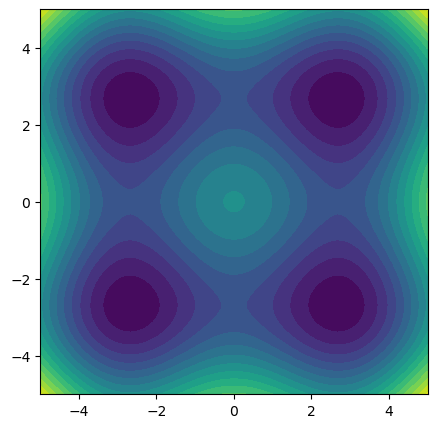

In [52]:
plt.figure(figsize=[5, 5])
cont = plt.contourf(X, Y, U,  contours)

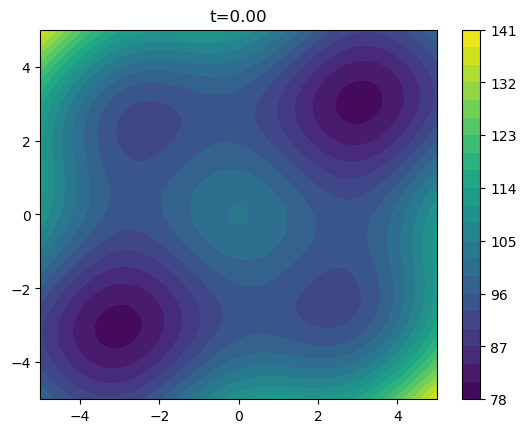

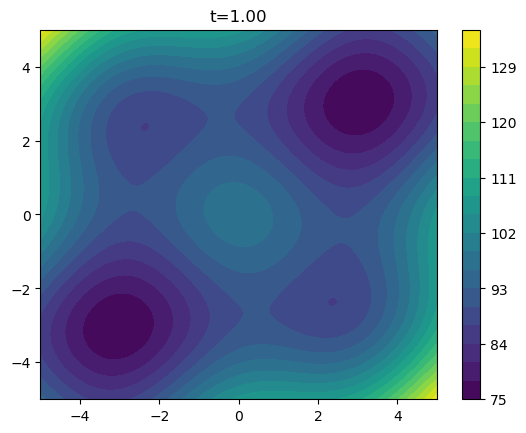

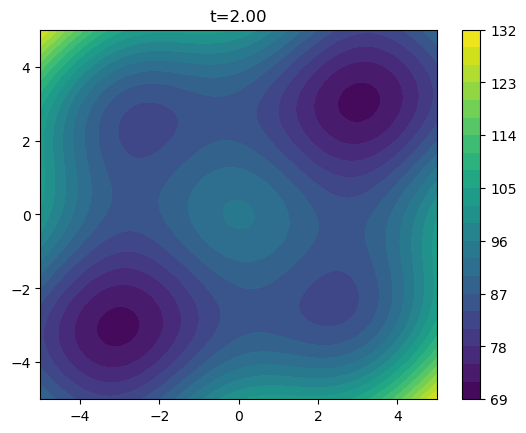

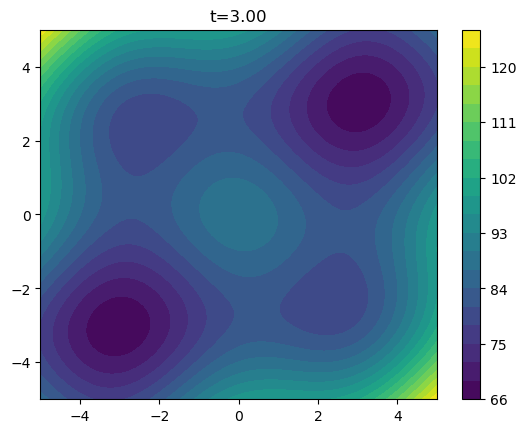

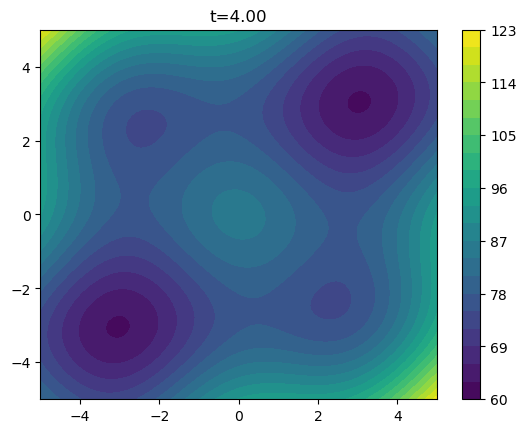

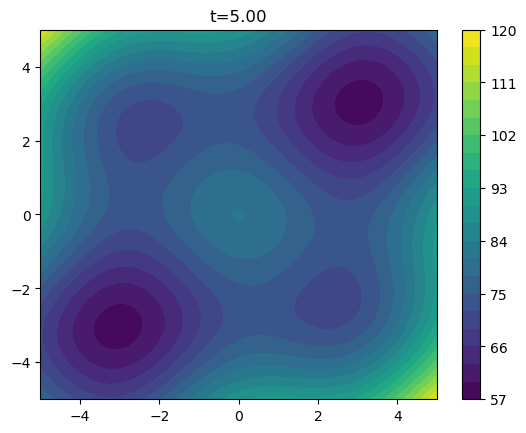

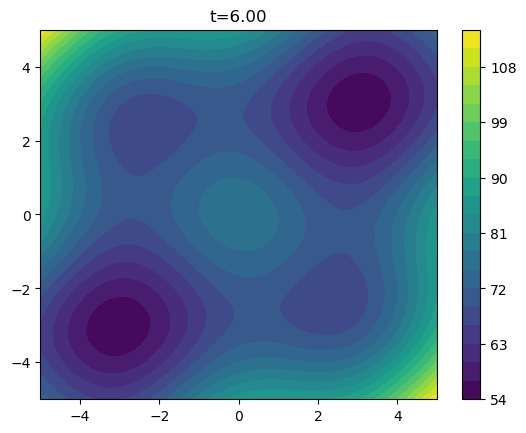

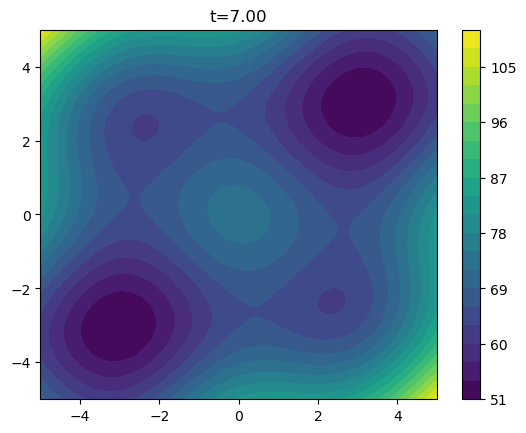

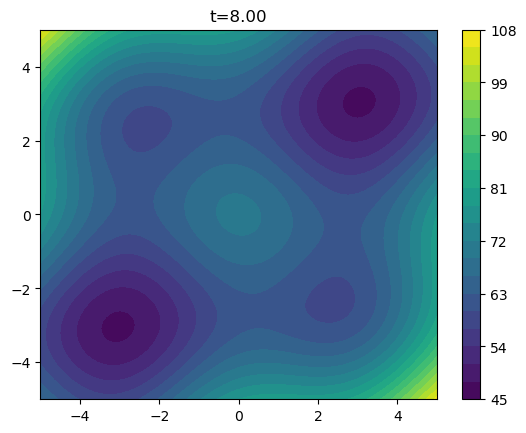

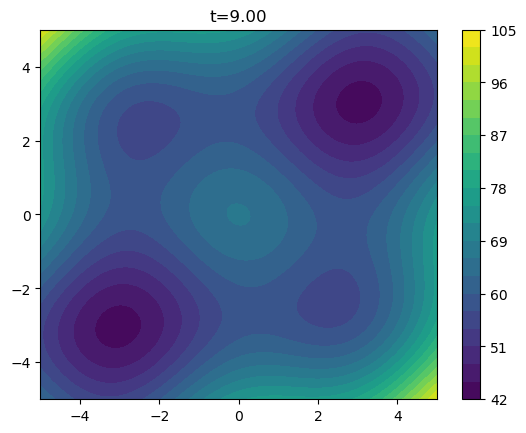

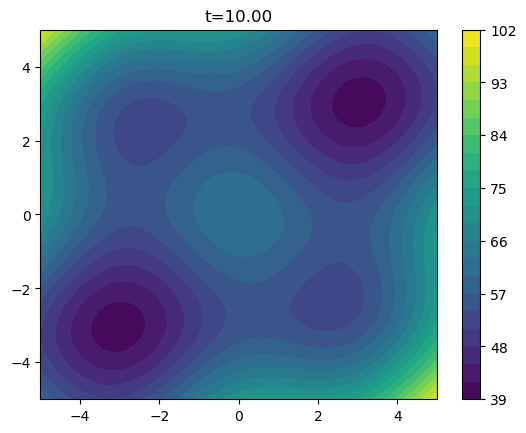

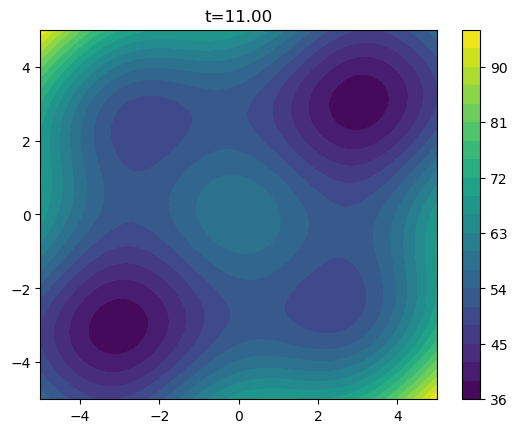

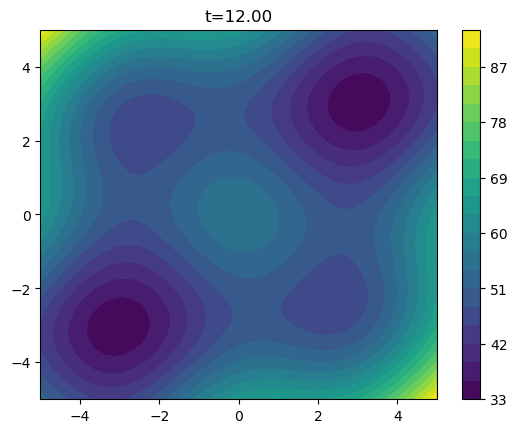

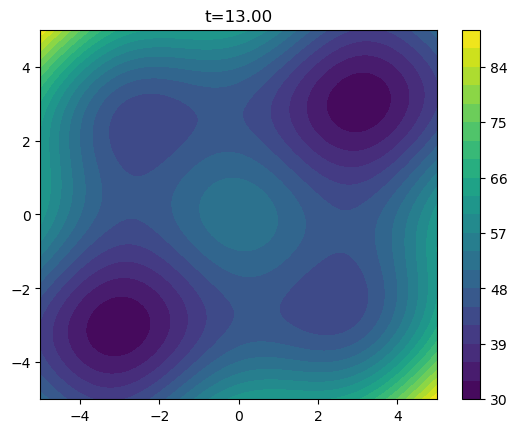

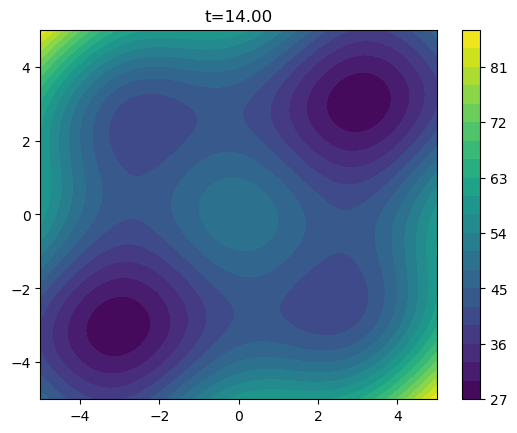

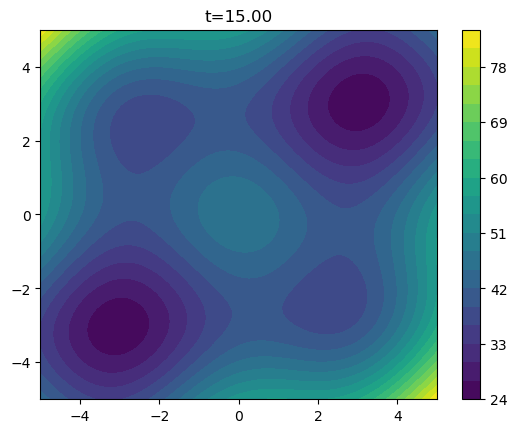

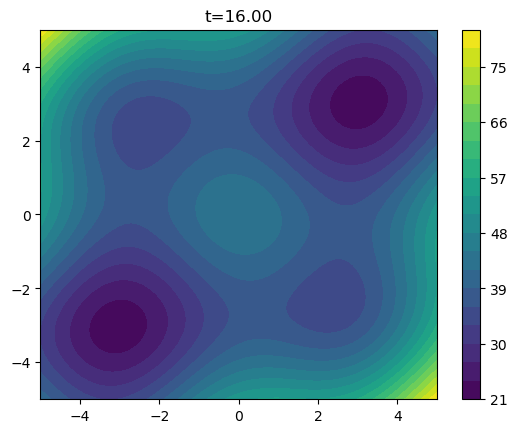

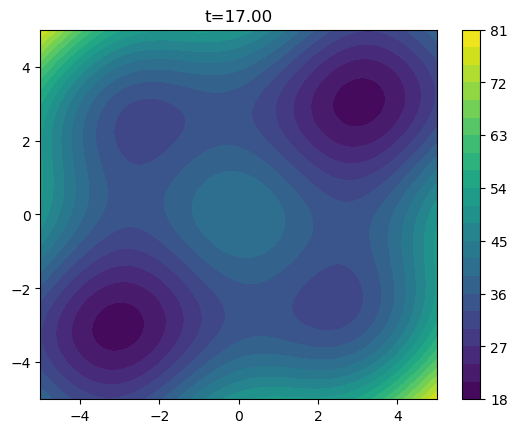

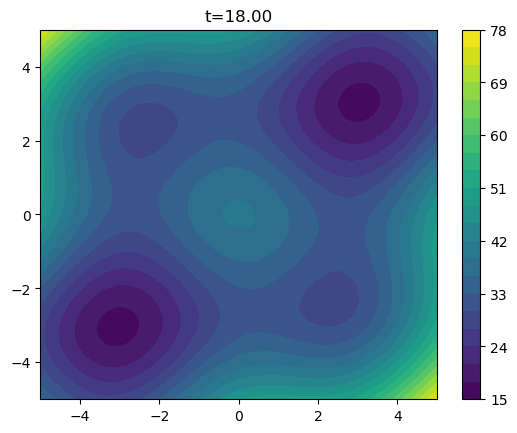

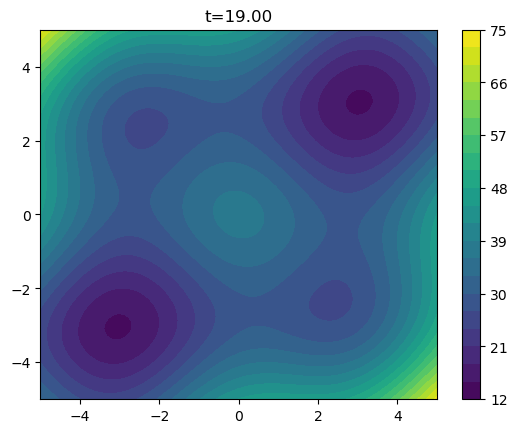

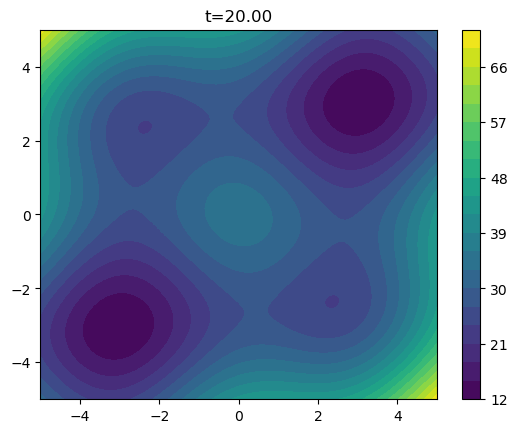

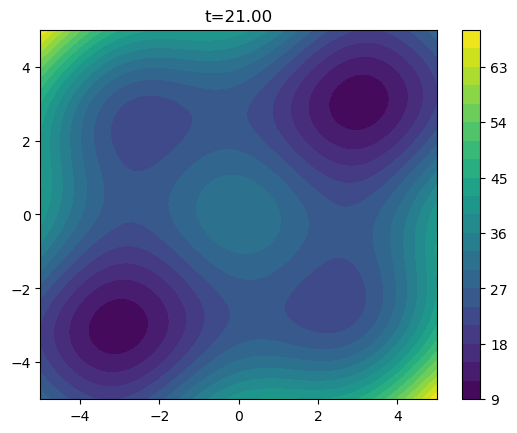

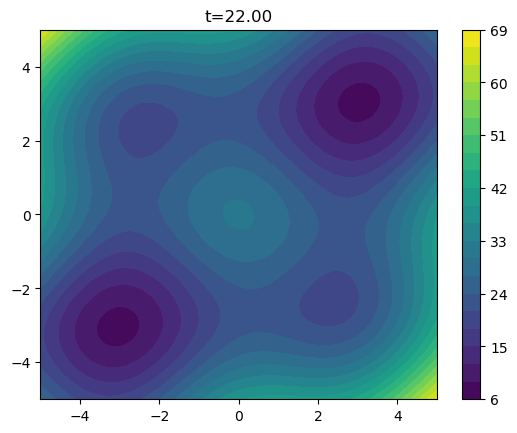

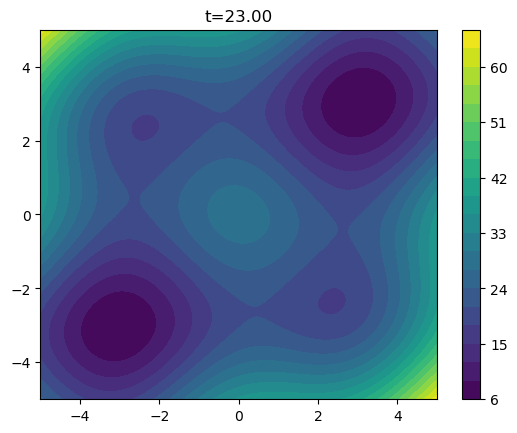

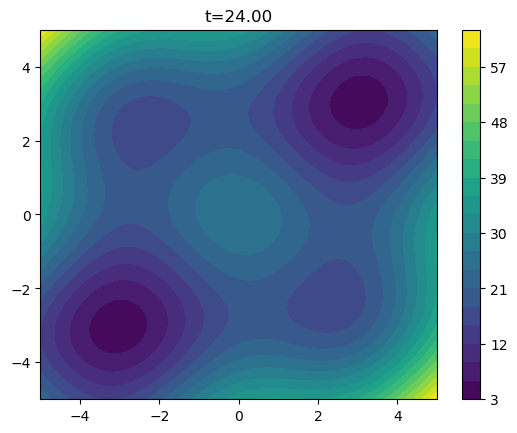

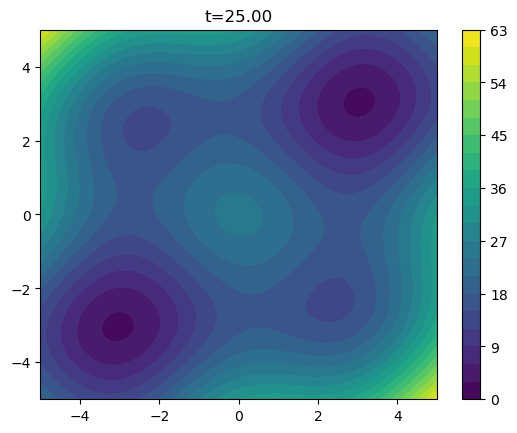

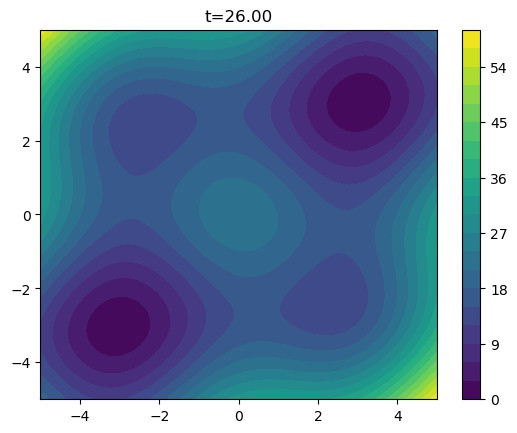

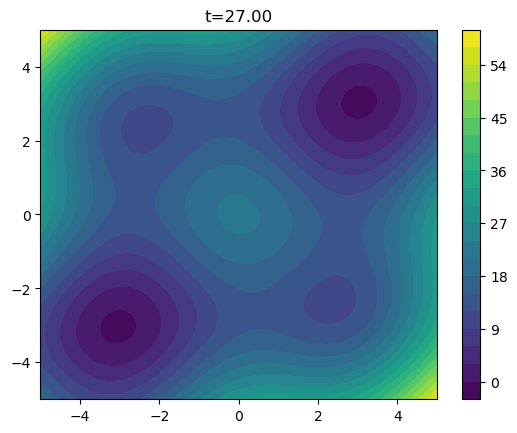

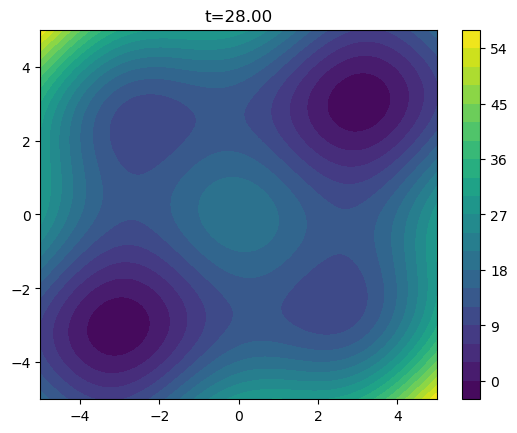

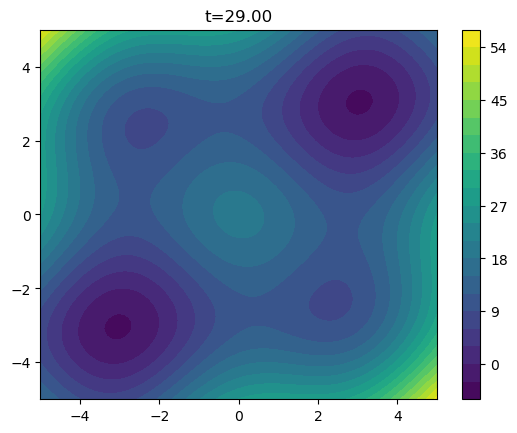

In [66]:
for x in range(0, 30):
    cfqr.system.show_potential(x, axis1=0, axis2=1, manual_domain = [[-5, -5], [5, 5]], contours=20)